In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
csv_path = "fashion_data/fashion_data/styles.csv"  # Path to styles.csv
train_dir = "fashion_data/fashion_data/train"      # Train folder
val_dir = "fashion_data/fashion_data/validate"     # Validation folder
test_dir = "fashion_data/fashion_data/test"        # Test folder

# Mapping categories to labels
label_map = {"Casual": 0, "Formal": 1, "Smart Casual": 2}

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,
    rescale= 1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def loadingWithAugmentation(csv_path, directory, limit, augment_categories=None):
    data = pd.read_csv(csv_path, on_bad_lines='skip')
    images, labels = [], []
    formal_images, smart_casual_images = [], []
    
    # Step 1: Loading all of theoriginal images then splitting  by category for augmentation
    for _, row in data.iterrows():
        img_id = str(row['id']) + ".jpg"
        category = row.get('usage')
        img_path = os.path.join(directory, img_id)

        if os.path.exists(img_path) and category in label_map:
            label = label_map[category]
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(60, 80))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            if category == 'Formal':
                formal_images.append(img_array)
            elif category == 'Smart Casual':
                smart_casual_images.append(img_array)
            else:
                images.append(img_array)
                labels.append(label)
    
    # Step 2: Augmenting the Formal and Smart Casual images 
    augmented_formal_images = augment_images(formal_images, limit, augment_categories, category="Formal")
    augmented_smart_casual_images = augment_images(smart_casual_images, limit, augment_categories, category="Smart Casual")
    
    images.extend(formal_images)
    labels.extend([label_map["Formal"]] * len(formal_images))
    
    images.extend(smart_casual_images)
    labels.extend([label_map["Smart Casual"]] * len(smart_casual_images))
    
    # Step 3: Add the augmented images into the dataset
    images.extend(augmented_formal_images)
    labels.extend([label_map["Formal"]] * len(augmented_formal_images))
    
    images.extend(augmented_smart_casual_images)
    labels.extend([label_map["Smart Casual"]] * len(augmented_smart_casual_images))
    
    images = np.array(images)
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_map))
    
    return images, labels

def augment_images(images_list, limit, augment_categories, category):#augmenting the images based on the limit given below for each of train, test, validate
    augmented_images = []
    
    # Check if there are images to augment
    if len(images_list) > 0 and category in augment_categories:
        aug_count = limit // len(images_list)  # Only augment if there are images to augment
        datagen.fit(np.array(images_list))
        
        for i in range(aug_count):
            for img_array in images_list:
                augmented_image = datagen.random_transform(img_array)
                augmented_images.append(augmented_image)
    
    return augmented_images

# Limits applied to match no. of causual clothes e.g if 100 in train, augment ~100 images to match
train_images, train_labels = loadingWithAugmentation(csv_path, train_dir, 800, augment_categories=["Formal", "Smart Casual"])
val_images, val_labels = loadingWithAugmentation(csv_path, val_dir, 200, augment_categories=["Formal", "Smart Casual"])
test_images, test_labels = loadingWithAugmentation(csv_path, test_dir, 200, augment_categories=["Formal", "Smart Casual"])

#Output dataset details 
print("Training dataset size:", train_images.shape, train_labels.shape)
print("Validation dataset size:", val_images.shape, val_labels.shape)
print("Test dataset size:", test_images.shape, test_labels.shape)


KeyboardInterrupt



In [ ]:
from keras import models, layers, optimizers
from tensorflow.keras.applications import ResNet50

#Load pre-trained ResNet50 and freeze its layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(60, 80, 3))
base_model.trainable = False  # Freeze all layers

#Add custom layers on top
network = models.Sequential()
network.add(base_model)
network.add(layers.GlobalAveragePooling2D())  # Optional
network.add(layers.Dropout(0.05))
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(3, activation='softmax'))

network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
network.summary()

In [ ]:
from keras import models, layers, optimizers


network = models.Sequential()
network.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(60, 80, 3)))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Conv2D(256, (3,3), activation='relu'))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(3, activation='softmax'))#3 classes (Casual, Formal, Smart Casual)
#Compiling the model for mult-class classification
network.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

network.summary()


In [19]:
# Train the model
history = network.fit(train_images, train_labels, epochs=10, steps_per_epoch=5, validation_data=(val_images, val_labels))


Epoch 1/10
5/5 [==============================] - 13s 2s/step - loss: 0.4717 - acc: 0.9145 - val_loss: 0.9840 - val_acc: 0.7407
Epoch 2/10
5/5 [==============================] - 13s 3s/step - loss: 0.3421 - acc: 0.9145 - val_loss: 0.8901 - val_acc: 0.7407
Epoch 3/10
5/5 [==============================] - 11s 2s/step - loss: 0.3238 - acc: 0.9145 - val_loss: 0.7677 - val_acc: 0.7407
Epoch 4/10
5/5 [==============================] - 12s 2s/step - loss: 0.3128 - acc: 0.9145 - val_loss: 0.8351 - val_acc: 0.7407
Epoch 5/10
5/5 [==============================] - 11s 2s/step - loss: 0.3019 - acc: 0.9145 - val_loss: 0.7986 - val_acc: 0.7407
Epoch 6/10
5/5 [==============================] - 10s 2s/step - loss: 0.2891 - acc: 0.9145 - val_loss: 0.6701 - val_acc: 0.7407
Epoch 7/10
5/5 [==============================] - 10s 2s/step - loss: 0.2732 - acc: 0.9145 - val_loss: 0.6843 - val_acc: 0.7407
Epoch 8/10
5/5 [==============================] - 9s 2s/step - loss: 0.2967 - acc: 0.9134 - val_loss: 0.

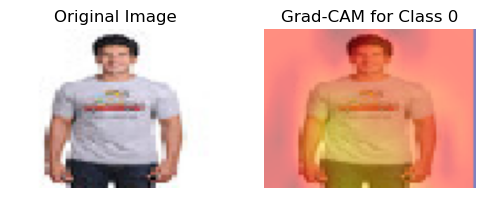

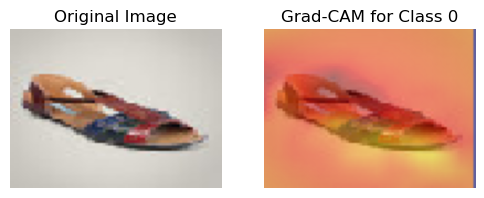

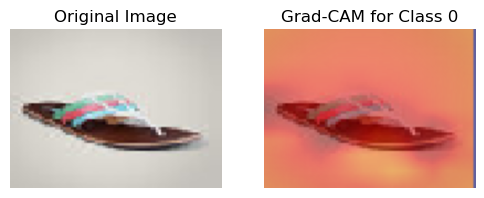

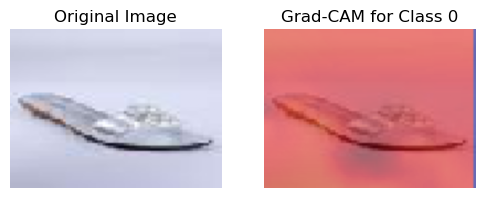

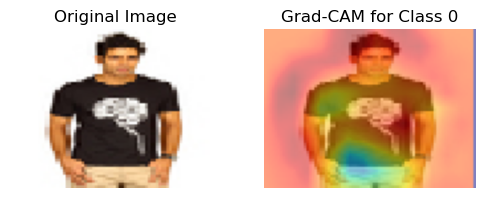

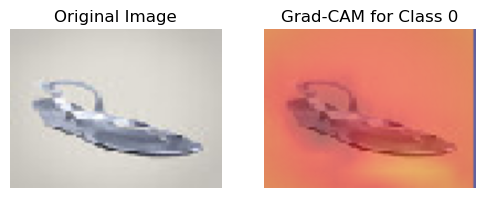

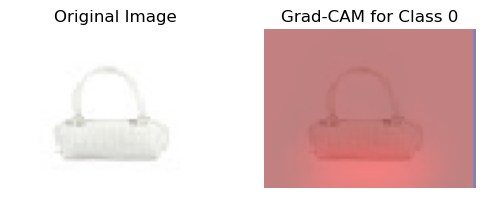

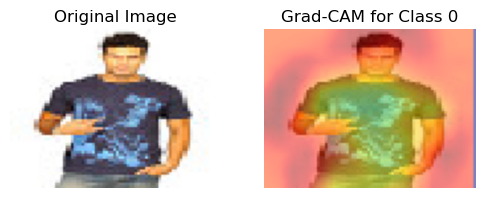

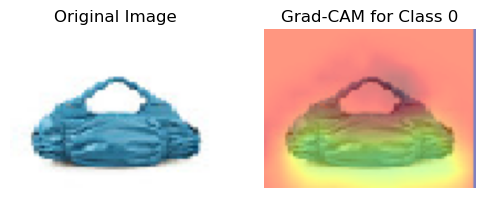

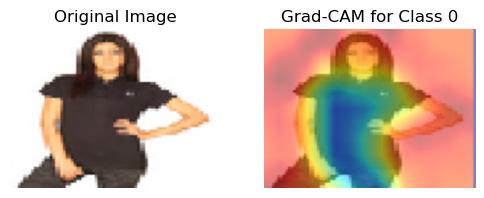

In [20]:
# Implementing the GRADCAM method to produce heatmaps
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# GradCAM Visualization
for i in range(0, 10):
    label = np.argmax(train_labels[i])  # Convert one-hot encoded label to class index
    seed_input_image = train_images[i]
    seed_input_image = np.expand_dims(seed_input_image, axis=0)  # Add batch dimension

    # Initialize GradCAM
    gradcam = Gradcam(model=network, model_modifier=ReplaceToLinear(), clone=False)
    cam = gradcam(CategoricalScore(label), seed_input_image)

    # Post-process heatmap
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Plot original image and heatmap overlay
    plt.figure(figsize=(6, 3))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(seed_input_image[0])  # Remove batch dimension for display
    plt.axis('off')
    plt.title('Original Image')

    # Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(seed_input_image[0])  # Display original image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.title(f'Grad-CAM for Class {label}')
    
    plt.show()


In [26]:
import pickle
# Save the history
with open("model_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Load the history
with open("model_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)

# Extract data
acc = loaded_history['acc']
val_acc = loaded_history['val_acc']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(1, len(acc) + 1)

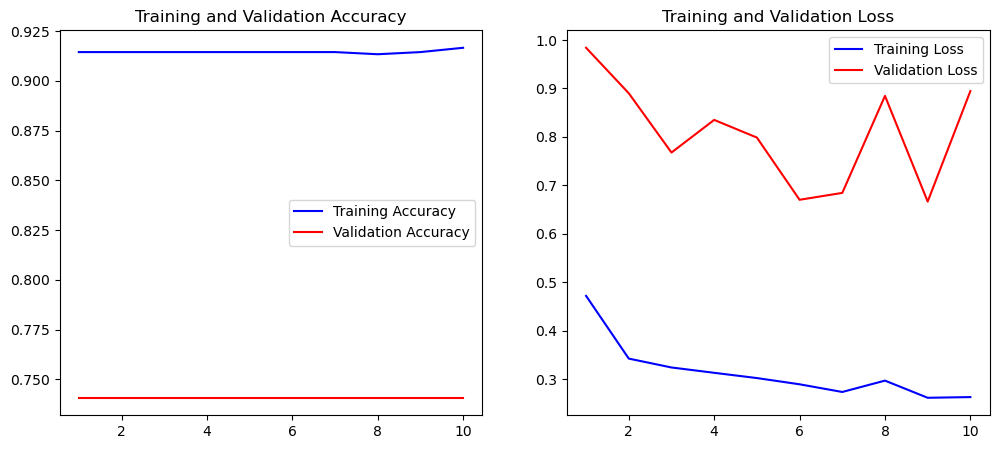

In [27]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()